# Tutorial for running the Python Inverse Problem Toolbox (PIPT)

<font size=4em>As an illustrative example we choose a small 3D-field with three producers and three (water) injectors. The figure below shows the true (data generating) permeability field and the well positions. The grid is 10x10x2, and the porosity is 0.2. The inverse problem is to find the permeability for the reservoir by assimilation produced water and oil and injected water. 

<img src="./permx.png?lastmod=12345678" alt="drawing" width="500"/>
<br>
<font size=4em>The first step is to load neccessary external and local modules. 

In [1]:
# Set width
from IPython.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

# Import global modules
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt  

# Import local modules
from pipt.loop.ensemble import Ensemble # this class contains the data
from pipt.loop.assimilation import Assimilate # this class contains the iterative assimilation loop
from subsurface.multphaseflow.opm import flow # the simulator we want to use
from input_output import read_config # functions for reading input
from pipt import pipt_init # script for initializing the module with the data assimilation method 
from plot_objective_function import combined # plot the data mismatch
from plot_parameters import plot_layer, export_to_grid # plot the parameters
from plot_data import plot_prod # plot the production data

<font size=4em>Set the random seed:

In [2]:
np.random.seed(10)    

<font size=4em>Remove old results and folders, if present:

In [3]:
for folder in glob('En_*'):
    shutil.rmtree(folder)
for file in glob('debug_analysis_step_*'):
    os.remove(file)

<font size=4em>Read inputfile. In this tutorial the input file is written as a .toml file, and consists of two main keys: <span style="font-family:Courier;">dataassim</span> and <span style="font-family:Courier;">fwdsim</span>. The first part contains the options for the data assimilation algorithm and the second part are options related to the forward simulation model. The description of all keys are provided in the printouts of method docstrings below.

In [4]:
!cat 3D_ESMDA.toml
kd, kf, ke = read_config.read_toml('3D_ESMDA.toml')

[ensemble]
ne = 50.0
state = "permx"
prior_permx = [["vario", "sph"], ["mean", "priormean.npz"], ["var", 1.0], ["range", 10.0], ["aniso", 1.0],
               ["angle", 0.0], ["grid", [10.0, 10.0, 2.0]]]
               
[dataassim]
daalg = ["esmda", "esmda"]
analysis = "approx"
energy = 98.0
obsvarsave = "yes"
restartsave = "no"
analysisdebug = ["pred_data", "state", "data_misfit", "prev_data_misfit"]
restart = "no"
obsname = "days"
truedataindex = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]
truedata = "true_data.csv"
assimindex = [0,1,2,3,4,5,6,7,8,9]
datatype = ["WOPR PRO1", "WOPR PRO2", "WOPR PRO3", "WWPR PRO1", "WWPR PRO2",
            "WWPR PRO3", "WWIR INJ1", "WWIR INJ2", "WWIR INJ3"]
staticvar = "permx"
datavar = "var.csv"
mda = [ ["tot_assim_steps", 3], ['inflation_param', [2, 4, 4]] ]

[fwdsim]
reporttype = "days"
reportpoint = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]
replace = "yes"
saveforecast = "yes"
sim_limit = 300.0
rerun = 1
runfile = "r

<font size=4em>Initialize the simulator with simulator keys.

In [5]:
sim = flow(kf)
print(flow.__init__.__doc__)


        The inputs are all optional, but in the same fashion as the other simulators a system must be followed.
        The input_dict can be utilized as a single input. Here all nescessary info is stored. Alternatively,
        if input_dict is not defined, all the other input variables must be defined.

        Parameters
        ----------
        input_dict : dict, optional
            Dictionary containing all information required to run the simulator.

                - parallel: number of forward simulations run in parallel
                - simoptions: options for the simulations
                    - mpi: option to use mpi (always use > 2 cores)
                    - sim_path: Path to the simulator
                    - sim_flag: Flags sent to the simulator (see simulator documentation for all possibilities)
                - sim_limit: maximum number of seconds a simulation can run before being killed
                - runfile: name of the simulation input file
             

<font size=4em>Print the Ensemble options:

In [6]:
print(Ensemble.__init__.__doc__)


        Parameters
        ----------
        keys_da : dict
            Options for the data assimilation class

            - daalg: spesification of the method, first the main type (e.g., "enrml"), then the solver (e.g., "gnenrml")
            - analysis: update flavour ("approx", "full" or "subspace")
            - energy: percent of singular values kept after SVD
            - obsvarsave: save the observations as a file (default false)
            - restart: restart optimization from a restart file (default false)
            - restartsave: save a restart file after each successful iteration (defalut false)
            - analysisdebug: specify which class variables to save to the result files
            - truedataindex: order of the simulated data (for timeseries this is points in time)
            - obsname: unit for truedataindex (for timeseries this is days or hours or seconds, etc.)
            - truedata: the data, e.g., provided as a .csv file
            - assimindex: ind

<font size=4em>Example using ESMDA. The input and available options are given below. During assimilation, useful information is written to the screen. The same information is also written to a log-file named pet_logger.log. 

In [7]:
analysis = pipt_init.init_da(kd, ke, sim)

print(analysis.__init__.__doc__)
assimilation = Assimilate(analysis)
assimilation.run()

Single entry for VARIO will be copied to all 2 layers
Single entry for VAR will be copied to all 2 layers
Single entry for ANISO will be copied to all 2 layers
Single entry for ANGLE will be copied to all 2 layers
Single entry for RANGE will be copied to all 2 layers

        The class is initialized by passing the keywords and simulator object upwards in the hierarchy.

        Parameters
        ----------
        keys_da['mda']: list
            - tot_assim_steps: total number of iterations in MDA, e.g., 3
            - inflation_param: covariance inflation factors, e.g., [2, 4, 4]

        keys_en : dict

        sim : callable

        References
        ----------
        [1] A. Emerick & A. Reynods, Computers & Geosciences, 55, p. 3-15, 2013
        


Iterations (Obj. func. val: ):   0%|                                                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Iterations (Obj. func. val: ):  25%|█████████████████████████████████████████████▎                                                                                                                                       | 1/4 [00:06<00:19,  6.58s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Iterations (Obj. func. val:749926.2 Reduced: 95 %):  50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 2/4 [00:13<00:13,  6.71s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Iterations (Obj. func. val:163815.9 Reduced: 78 %):  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3/4 [00:20<00:06,  6.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Iterations (Obj. func. val:14396.2 Reduced: 91 %): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.76s/it]

Convergence was met. Obj. function reduced from 14994770.0 to 14396.2


<font size=4em>Plot the data mismatch:

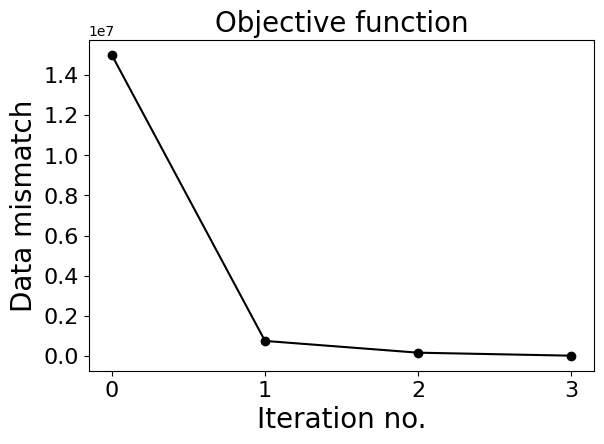

In [8]:
combined()

<font size=4em>Plot the prior and posterior permeability in the upper layer:

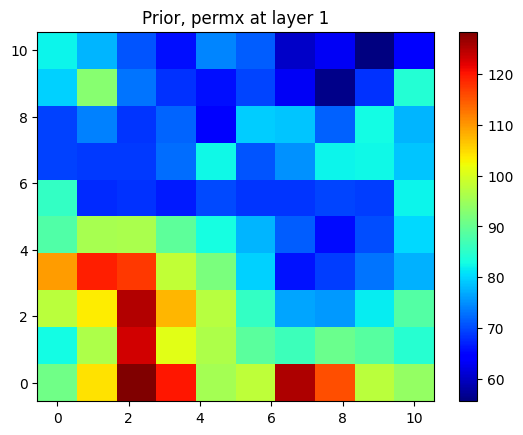

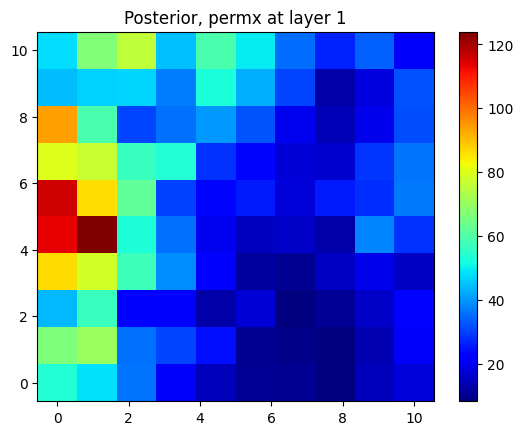

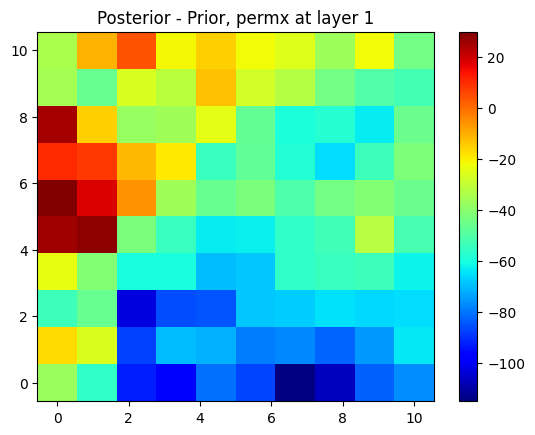

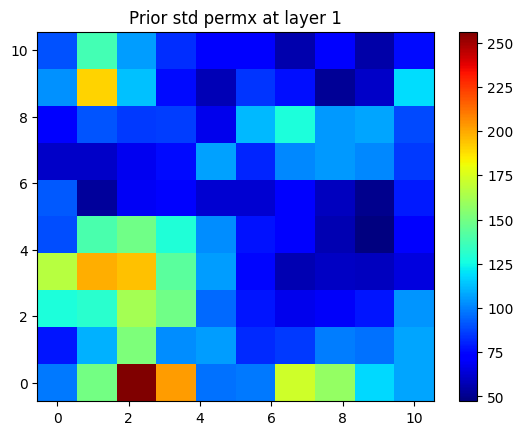

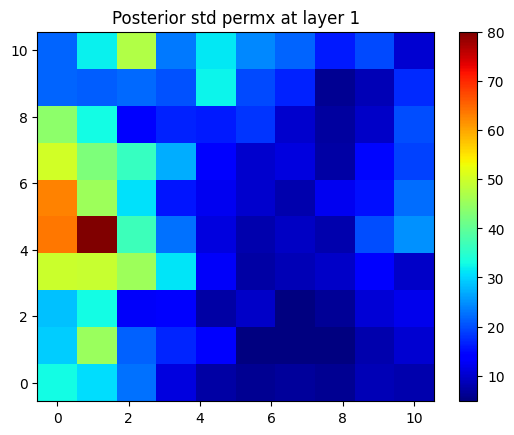

In [9]:
export_to_grid('permx')
plot_layer('permx', [2, 10, 10])

WOPR PRO1


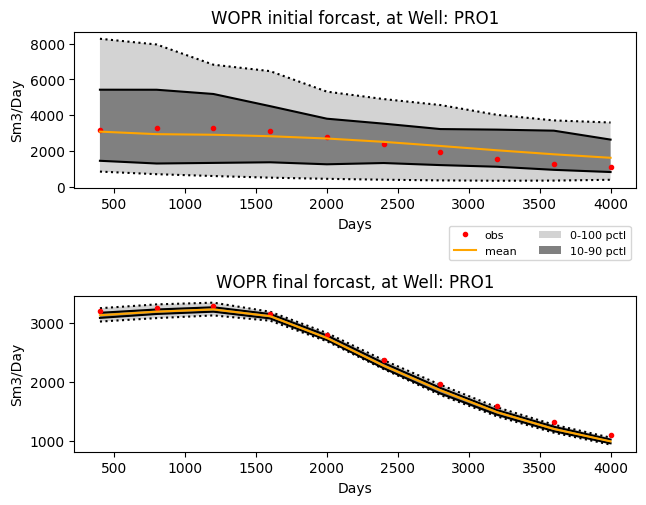

WOPR PRO2


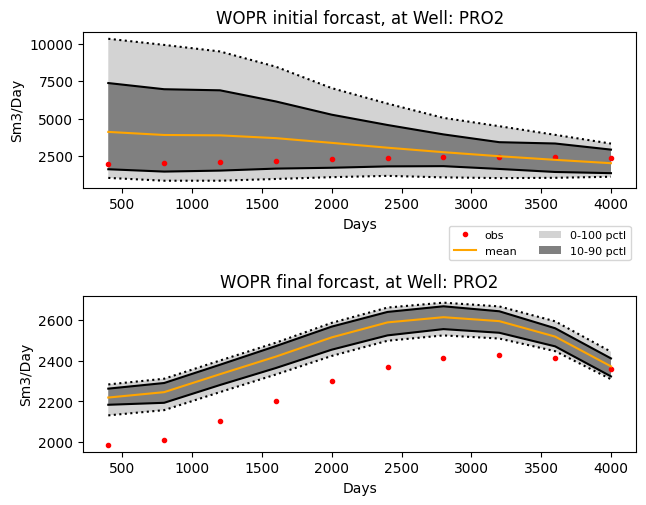

WOPR PRO3


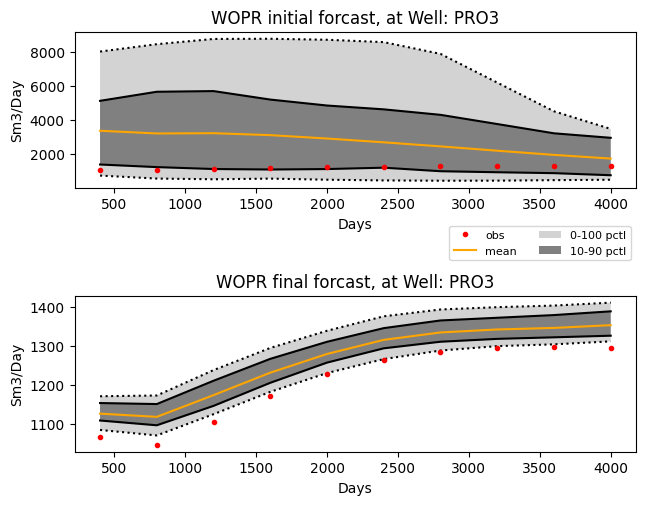

WWPR PRO1


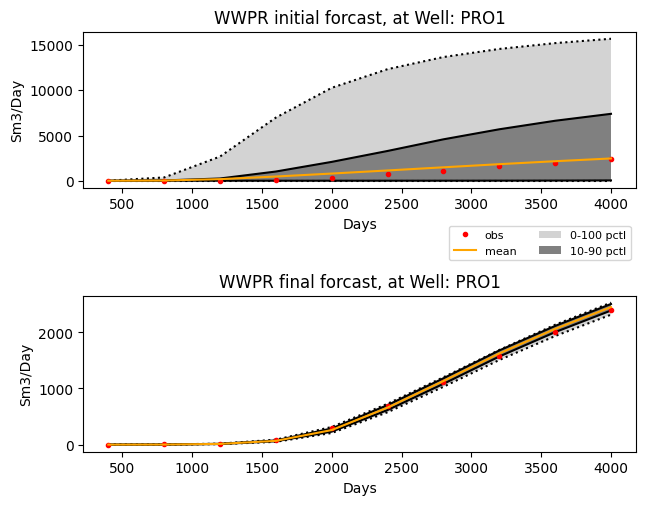

WWPR PRO2


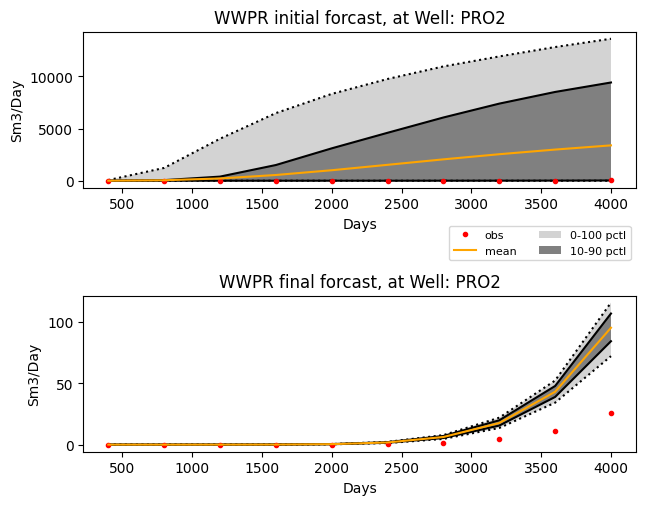

WWPR PRO3


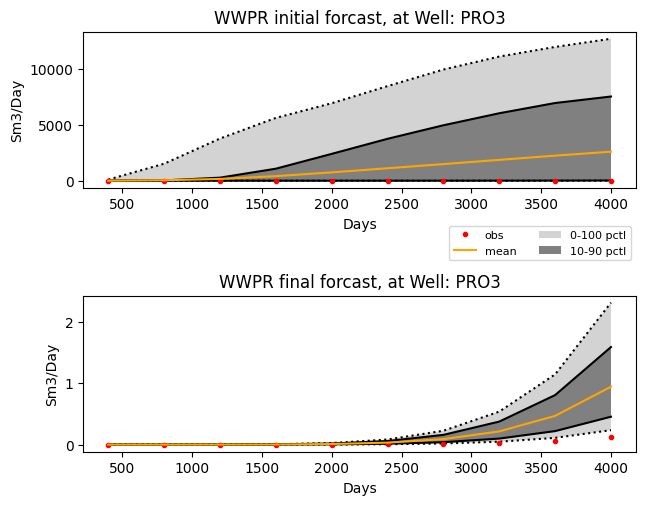

WWIR INJ1


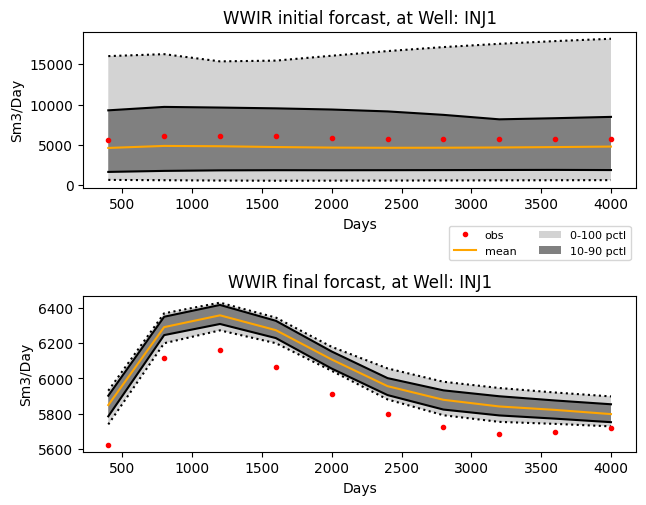

WWIR INJ2


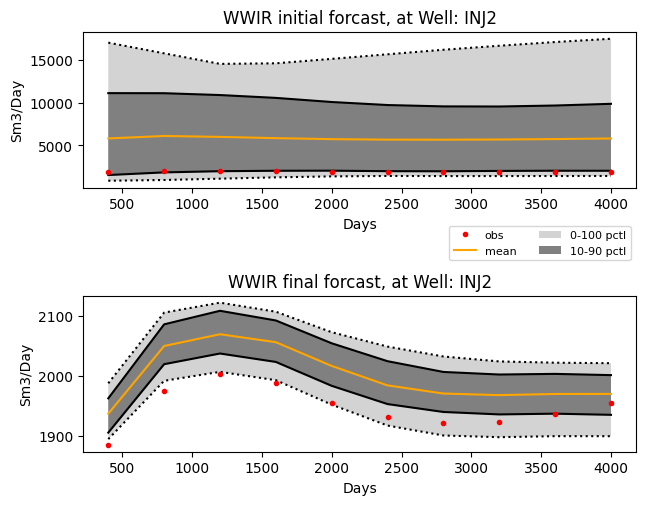

WWIR INJ3


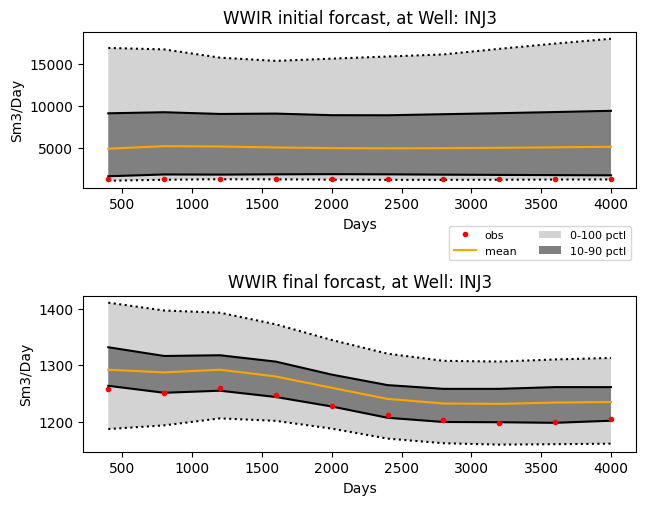

In [10]:
plot_prod()

## Setting up the .mako file
<font size=4em>The data assimilation relies on a .mako file for writing the current state variables to the flow simulator input. In this case, the flow simulator is opm-flow [opm-projects.org](opm-projects.org), and the input file is provided as a text file (.DATA file). The .mako file is created by replacing the keywords <span style="font-family:Courier;">PERMX</span> in the .DATA file with: 
    
    PERMX
    % for i in range(0, len(permx)):
    % if permx[i] < 6:
    ${"%.3f" %(np.exp(permx[i]))}
    % else:
    ${"%.3f" %(np.exp(6))}
    % endif
    % endfor
    /

## Running locally

<font size=4em>It is recommended to run the notebook from a virtual environment. Follow these steps to run this notebook on your own computer: 
    
<font size=4em>*Step 1: Create virtual environment as normal*

    python3 -m venv pet_venv

<font size=4em>Then activate the environment using:

    source pet_venv/bin/activate

<font size=4em>*Step 2: Install Jupyter Notebook into virtual environment*

    python3 -m pip install ipykernel

<font size=4em>*Step 3: Install PET in the virtual environment, see [PET installation](https://github.com/Python-Ensemble-Toolbox/PET)*
    
<font size=4em>*Step 4: Install Plotting in the virtual environment, see [Plotting installation](https://github.com/Python-Ensemble-Toolbox/Plotting)*

<font size=4em>*Step 5: Allow Jupyter access to the kernel within the virtual environment*

    python3 -m ipykernel install --user --name=pet_venv

<font size=4em>Start jupyter notebook, and load tutorial_popt.ipynb (this file). On the jupyter notebook toolbar, select ‘Kernel’ and ‘Change Kernel’. The new kernel is now be available in the list for selection:
    
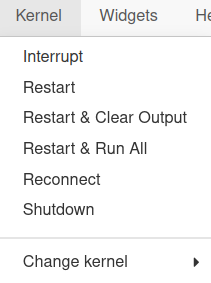